In [367]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import KBinsDiscretizer



PERCENTILES = [1, 5, 10, 15, 20] # Top 1%, 5%, 10%, 15%, 20% of predictions
ITERATIONS = 100  # Bootstrap iterations
COLORS = ['#323694', '#039573', '#feea2a'] # Color palette for the classifiers


# CMIM ranking of features 
CMIM_SC_NO_GENPROT = ['paralagous_count', 'upstream_size',  'CAI', 'GLU',
                'aromaticity_score', 'Gravy_score', 'downstream_size',
               'PI', 'MET', 'ASP', 'GLN',  'LYS', 'FOP_score', 'ARG',  'Codon_bias']

CMIM_SC_GENPROT = ['phyletic_retention', 'paralagous_count', 'upstream_size',  'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
               'PI', 'MET', 'ASP', 'GLN',  'LYS', 'FOP_score', 'ARG']

CMIM_SC_ALL = ['phyletic_retention', 'paralagous_count', 'DIP_degree', 'nucleolus',
                'nucleus', 'upstream_size', 'spindle pole', 'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
                'vacuole', 'endosome', 'mitochondrion', 'PI', 'cytoplasm',
                'promoter_count(Harbison_et_al)', 'vacuolar membrane', 'MET', 'ASP',
                'ER to Golgi', 'GLN', 'peroxisome', 'num places loc', 'LYS',
                'ambiguous', 'cell periphery', 'FOP_score', 'nuclear periphery', 'ARG',
                'Golgi to ER', 'punctate composite', 'ER', 'lipid particle', 'microtubule',
                'Golgi', 'bud neck', 'actin', 'bud', 'Golgi to Vacuole']


## `EssentiallyClassifier` Class

The `EssentiallyClassifier` class is an abstract base class designed to be implemented by diffent classifiers algorithms provviding a common interface for all classifiers.

In [368]:

class EssentiallyClassifier:
    """
    Abstract class for the essentiality classifier.
    Contains the main methods to load the data, find the optimal number of features and plot the results.
    """

    def __init__(self, file_path, cmim_ranking, percentiles,name):
        self.name = name # Name of classifier
        self.file_path = file_path # Path to the excel file
        self.cmim_ranking = cmim_ranking # CMIM ranking of features 
        self.percentiles = percentiles # Top percentiles 
        self.X = None
        self.y = None
        self.optimal_features = None
        self.highest_ppv_5 = 0 # Highest PPV (5%), used to find optimal number of features 
        self.final_ppv_scores = []

        self.categories = None


    def load_discretized_data(self):
        """
        Loads and processes discretized data from an Excel file.
        Reads data and uses a label encoder to convert symbols to integers.
        """

        self.load_discretized_data_3();
        return;

        discretized_data = pd.read_excel(self.file_path, sheet_name='entropy discretized')
        columns_with_symbols = discretized_data.columns[2:]
        label_encoders = {}

        for column in columns_with_symbols:
            le = LabelEncoder()
            discretized_data[column] = le.fit_transform(discretized_data[column].astype(str))
            label_encoders[column] = le

        self.X = discretized_data.drop(columns=['Essential', 'orf_id'])
        self.y = discretized_data['Essential']

        print("Data loaded successfully, shape:", self.X.shape, self.y.shape)

        discretized_data.to_excel(f'./output/{self.name}_processed_features_.xlsx', index=False)


    def load_discretized_data_2(self):
        discretized_data = pd.read_excel(self.file_path)
        columns_with_symbols = discretized_data.columns[3:]
        
        # Convert columns to numeric
        columns_numeric = discretized_data[columns_with_symbols].apply(pd.to_numeric, errors='coerce')
        
        # Ensure the data is a 2D ndarray for KBinsDiscretizer
        X_numeric = columns_numeric.values  # Convert the DataFrame to a 2D NumPy ndarray
        
        discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')  # 10 categories
        X_discretized = discretizer.fit_transform(X_numeric)
        
        # Return the discretized data as a DataFrame
        self.X = pd.DataFrame(X_discretized, columns=columns_numeric.columns)
        self.y = discretized_data['Essential']




        min_categories = self.X.nunique()
        self.categories = min_categories  

        
        print("Data loaded successfully, shape:", self.X.shape, self.y.shape)

        self.X.to_excel(f'./output/{self.name}_processed_features_.xlsx', index=False)


    def load_discretized_data_3(self):
        discretized_data = pd.read_excel(self.file_path, sheet_name='entropy discretized')
        columns_with_symbols = discretized_data.columns[2:]
        label_encoders = {}

        for column in columns_with_symbols:
            le = LabelEncoder()
            discretized_data[column] = le.fit_transform(discretized_data[column].astype(str))
            label_encoders[column] = le

        self.X = discretized_data.drop(columns=['Essential', 'orf_id'])
        self.y = discretized_data['Essential']


        min_categories = self.X.nunique()
        self.categories = min_categories  

        print(self.categories.head())


        print("Data loaded successfully, shape:", self.X.shape, self.y.shape)


    def calculate_top_percentile_ppv(self, probabilities, true_labels):
        """
        Calculate the positive predictive value (PPV) for the top percentiles of predictions.

        Parameters:
            - probabilities: Array of predicted probabilities.
            - true_labels: Grand truth labels.
        
        Returns:
        - PPV values for each specified percentile in self.percentiles.
        """

        if len(probabilities) != len(true_labels):
            raise ValueError("Length of probabilities and true labels must be the same.")

        sorted_indices = np.argsort(probabilities)[::-1] # Sort probabilities in descending order so that the top probabilities are first
        sorted_labels = true_labels[sorted_indices] # Sort true labels according to the sorted probabilities
        ppv_percentiles = []

        for p in self.percentiles:
            n_top = int(len(sorted_labels) * (p / 100)) # Calc the number of top predictions to consider
            if n_top == 0:
                ppv_percentiles.append(0)
            else:
                top_labels = sorted_labels[:n_top]
                # def: PPV = TP / (TP + FP)
                ppv = np.sum(top_labels) / len(top_labels)
                ppv_percentiles.append(ppv)

        return ppv_percentiles


    def find_optimal_features(self):
        """
        Find the optimal number of features to use by evaluating the classifier with different number 
        of features taken ordered by CMIM ranking.
        """

        # Only features of the specific feature set 
        X_ranked = self.X[self.cmim_ranking]

        print("Starting to find optimal number of features...")

        # Iterate over all the features in the specific CMIM ranking
        for i in range(len(self.cmim_ranking), 0, -1):
            X_selected = X_ranked.iloc[:, :i]

            # Evaluate the model with the selected features
            ppv = self.evaluate_model(X_selected)
            
            ppv_1 = ppv[0] # PPV (1%)
            ppv_5 = ppv[1] # PPV (5%)
            print(f"Features: {i}, PPV (1%): {ppv_1}, PPV (5%): {ppv_5}")

            # Update the highest PPV (1%) and optimal number of features
            if ppv_5 > self.highest_ppv_5 and ppv_1 > ppv_5:
                self.highest_ppv_5 = ppv_5
                self.optimal_features = i


        # Print the results
        print("Highest PPV (5%):", self.highest_ppv_5)
        print("Optimal number of features:", self.optimal_features, self.cmim_ranking[:self.optimal_features])



    def evaluate_final_model(self):
        """
        Evaluate the final model with the optimal number of features.
        """

        if self.optimal_features is None:
            raise ValueError("Optimal number of features to use has not been found.") 

        # Use the optimal number of features found empirically
        X_optimal = self.X[self.cmim_ranking].iloc[:, :self.optimal_features]


        # Evaluate the model with the optimal number of features
        self.final_ppv_scores = self.evaluate_model(X_optimal)
    
        print("Final PPV Percentiles:", self.final_ppv_scores)
        
        return self.final_ppv_scores



    def plot_ppv_results(self, ppv):
        """
        Plot the PPV results for the final model and compare with random predictions.

        Parameters:
            - ppv: Array of PPV values for the top percentiles of predictions of the classifier.
        """

        fig, ax = plt.subplots(figsize=(6, 4))
        percentiles_labels = [f'{p}%' for p in self.percentiles]
        random_ppv = [np.mean(self.y)] * len(self.percentiles)
        bar_with = 0.2

        ax.bar(np.arange(len(self.percentiles)) - bar_with / 2, ppv, bar_with, label=self.name, color='blue')
        ax.bar(np.arange(len(self.percentiles)) + bar_with / 2, random_ppv, bar_with, label='Random', color='black')
        ax.set_xlabel('Top Percentage of Predictions')
        ax.set_ylabel('PPV (%)')
        ax.set_title(f'PPV for {self.name} vs Random')
        ax.set_xticks(np.arange(len(self.percentiles)))
        ax.set_xticklabels(percentiles_labels)
        ax.set_ylim(0, 1)
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.legend()
        fig.tight_layout()
        plt.show()



    def run(self):
        """
        Build, optimize and evaluate the classifier.
        """

        self.load_discretized_data()
        self.find_optimal_features() 
        #self.optimal_features = 4
        ppvs = self.evaluate_final_model()
        self.plot_ppv_results(ppvs)



    def evaluate_model(self, X_selected):
        """
        Evaluate the model with the selected features and calculate the PPV for the top percentiles of predictions.

        Parameters:
        - X_selected: Selected features to use for the model.
        
        Returns:
        - PPV values for the top percentiles of predictions.

        To be implemented by the subclass.
        """
        pass


## `EssentiallyBayesClassifier` Class

The `EssentiallyBayesClassifier` class is a specialized implementation of the `EssentiallyClassifier` abstract base class. It utilizes a Naive Bayes classifier to perform essentiality prediction tasks. 
The implementation uses the boostrapping technique.


In [369]:
class EssentiallyBayesClassifier(EssentiallyClassifier):
    """
    Naive Bayes classifier for the essentiality prediction.
    """

    def __init__(self, file_path, cmim_ranking, percentiles, name):
        super().__init__(file_path, cmim_ranking, percentiles ,name)


    def calcolate_boostrap_iteration(self, X_selected):
        """
        Helper function to calculate the single bootstrap iteration for the Naive Bayes classifier.

        Parameters:
            - X_selected: Selected features to use.

        Returns:
            - PPV values for the top percentiles of predictions.
        """


        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, self.y, test_size=0.5, stratify=self.y)


        # TODO
        # X_train_minority = X_train[y_train == 1]
        # y_train_minority = y_train[y_train == 1]

        # X_train_oversampled, y_train_oversampled = resample(
        #     X_train_minority, y_train_minority,
        #     replace=True,
        #     n_samples=np.sum(y_train == 0),
        #     random_state=42
        # )

        # X_train_oversampled = X_train_minority
        # y_train_oversampled = y_train_minority

        # X_train_balanced = pd.concat([X_train[y_train == 0], X_train_oversampled])
        # y_train_balanced = pd.concat([y_train[y_train == 0], y_train_oversampled])

        X_train_balanced = X_train
        y_train_balanced = y_train

        selected_categories = self.categories[X_selected.columns].to_numpy()
   
        
        nb_classifier = CategoricalNB(min_categories=selected_categories)
        nb_classifier.fit(X_train_balanced, y_train_balanced)
        y_prob = nb_classifier.predict_proba(X_test)[:, 1]

        return self.calculate_top_percentile_ppv(y_prob, y_test.to_numpy())

   
    # Override 
    def evaluate_model(self, X_selected):
        all_ppvs = []
        for _ in range(ITERATIONS):  # Bootstrap iterations
            ppv_iteration = self.calcolate_boostrap_iteration(X_selected)
            all_ppvs.append(ppv_iteration)

        # Calculate the mean PPV for each percentile over all iterations
        final_ppv = np.mean(all_ppvs, axis=0)
        return final_ppv

## `EssentialityExperiment` Class

The `EssentialityExperiment` class is designed to manage and run and compare multiple classifiers.
It inclueds methods for executing experiments, visualizing omparative tables and plots.


In [370]:
class EssentialityExperiment:
    def __init__(self, name, classifiers):
        self.name = name # Name of the experiment
        self.classifiers = classifiers # Classifiers to run and compare

    def run_experiment(self):
        """
        Runs all the classifiers and evaluates their performance.
        """

        print("-" * 80)
        print(f"Running experiment for {self.name}")
        print("Classifiers: ", [classifier.name for classifier in self.classifiers])
        print("-" * 80)


        for classifier in self.classifiers:
            print(f"Running classifier {classifier.name}")
            print("-" * 50)
            classifier.run()
    
    def plot_and_save_comparative_results(self, percentiles, colors=None):
        """
        Plot the comparative results of the classifiers.
        """

        if colors is None:
            colors = plt.cm.get_cmap('tab10').colors # get default color map if not specified

        fig, ax = plt.subplots(figsize=(6, 4))
        labels = [f'{p}%' for p in percentiles]
        x = np.arange(len(percentiles))
        bar_width = 0.1
        gap = 0.03  # Gap between bars in the same group

        # Plot the PPV scores for each classifier
        for idx, classifier in enumerate(self.classifiers):
            ax.bar(x + idx * (bar_width + gap), 
                np.array(classifier.final_ppv_scores) * 100,  
                bar_width, 
                label=classifier.name, 
                color=colors[idx % len(colors)],
                edgecolor='black', 
                linewidth=0.4)  

        # Random predictions
        random_ppv = [np.mean(self.classifiers[0].y) * 100] * len(percentiles)
        ax.bar(x + (len(self.classifiers)) * (bar_width + gap), 
            random_ppv, 
            bar_width, 
            label='Random', 
            color='black', 
            edgecolor='black', 
            linewidth=0.5)

        ax.set_xlabel('Top Percentage of Predictions')
        ax.set_ylabel('PPV (%)')
        ax.set_title(self.name)
        ax.set_xticks(x + (len(self.classifiers) / 2) * (bar_width + gap) )
        ax.set_xticklabels(labels)
        ax.set_ylim(0, 100) 
        ax.legend()
        fig.tight_layout()
        plt.show()

        # Save the plot to a file
        fig.savefig(f'./output/{self.name}_ppv_plot.png')


    def plot_and_save_comparative_table(self):
        """
        Plot a comparative table of the final PPV scores for each classifier.
        """
 
        rows = []
        for classifier in self.classifiers:
            if len(classifier.final_ppv_scores) != len(PERCENTILES):
                raise ValueError(
                    f"Inconsistent length for classifier '{classifier.name}': "
                    f"expected {len(PERCENTILES)} scores, got {len(classifier.final_ppv_scores)}."
                )
            rounded_scores = [str(round(score, 2)) for score in classifier.final_ppv_scores]
            rows.append(
                [classifier.name] + rounded_scores + [classifier.optimal_features]
            )

        # Create DataFrame
        columns = ['Classifier'] + [f'{p}%' for p in PERCENTILES] + ['Number of Features']
        table_df = pd.DataFrame(rows, columns=columns)
        table_df.set_index('Classifier', inplace=True)

        # Define a color palette for each row
        colors = [f'{color}50' for color in COLORS]  # Add alpha chanel to colors
        color_map = {classifier.name: colors[i % len(colors)] for i, classifier in enumerate(self.classifiers)}

     
        def highlight_row(row):
            classifier = row.name
            color = color_map.get(classifier, '#FFFFFF')  
            return [f'background-color: {color};'] * len(row)

        styled_df = table_df.style.apply(highlight_row, axis=1)


        styled_df = styled_df.set_table_attributes('style="font-size: 14px; border-collapse: collapse;"')


        # Save the table to a CSV file
        table_df.to_csv(f'./output/{self.name}_ppv_table.csv')


        return styled_df


In [371]:
class EssentialityRandomForestClassifier(EssentiallyClassifier):
    """
    Random Forest classifier for the essentiality prediction.
    """


    def __init__(self, file_path, cmim_ranking, percentiles, name):
        super().__init__(file_path, cmim_ranking, percentiles,name)

   
    # Override
    def evaluate_model(self, X_selected):

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, self.y, test_size=0.5, stratify=self.y)

        X_train_minority = X_train[y_train == 1]
        y_train_minority = y_train[y_train == 1]

        X_train_oversampled, y_train_oversampled = resample(
            X_train_minority, y_train_minority,
            replace=True,
            n_samples=np.sum(y_train == 0),
            random_state=42
        )

        # X_train_balanced = pd.concat([X_train[y_train == 0], X_train_oversampled])
        # y_train_balanced = pd.concat([y_train[y_train == 0], y_train_oversampled])

        X_train_balanced = X_train
        y_train_balanced = y_train


        # Build the Random Forest classifier
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

        # Train the Random Forest classifier
        rf_classifier.fit(X_train_balanced, y_train_balanced)
        y_prob = rf_classifier.predict_proba(X_test)[:, 1]

        ppv_iteration = self.calculate_top_percentile_ppv(y_prob, y_test.to_numpy())
        return ppv_iteration



upstream_size                     3
downstream_size                   2
paralagous_count                  3
phyletic_retention                6
promoter_count(Harbison_et_al)    2
dtype: int64
Data loaded successfully, shape: (4728, 42) (4728,)
Starting to find optimal number of features...
Features: 42, PPV (1%): 0.9147826086956522, PPV (5%): 0.755084745762712
Features: 41, PPV (1%): 0.9182608695652175, PPV (5%): 0.7565254237288133
Features: 40, PPV (1%): 0.9200000000000003, PPV (5%): 0.7593220338983054
Features: 39, PPV (1%): 0.9208695652173918, PPV (5%): 0.7608474576271189
Features: 38, PPV (1%): 0.9217391304347834, PPV (5%): 0.7596610169491526
Features: 37, PPV (1%): 0.9204347826086956, PPV (5%): 0.7614406779661017
Features: 36, PPV (1%): 0.9126086956521743, PPV (5%): 0.7577966101694917
Features: 35, PPV (1%): 0.9260869565217398, PPV (5%): 0.755084745762712
Features: 34, PPV (1%): 0.9169565217391308, PPV (5%): 0.75593220338983
Features: 33, PPV (1%): 0.922173913043479, PPV (5%): 0.

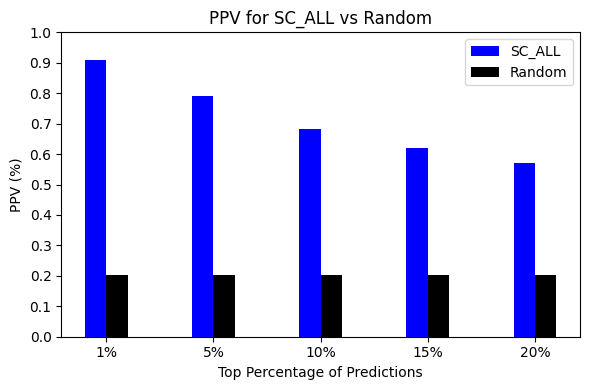

In [372]:
classifier_all = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, name='SC_ALL')
classifier_all.run()



--------------------------------------------------------------------------------
Running experiment for S. cerevisiae
Classifiers:  ['SC_ALL', 'SC_GENPROT', 'SC_NO_GENPROT']
--------------------------------------------------------------------------------
Running classifier SC_ALL
--------------------------------------------------
upstream_size                     3
downstream_size                   2
paralagous_count                  3
phyletic_retention                6
promoter_count(Harbison_et_al)    2
dtype: int64
Data loaded successfully, shape: (4728, 42) (4728,)
Starting to find optimal number of features...
Features: 42, PPV (1%): 0.9286956521739137, PPV (5%): 0.7602542372881352
Features: 41, PPV (1%): 0.9169565217391313, PPV (5%): 0.7527118644067798
Features: 40, PPV (1%): 0.9200000000000006, PPV (5%): 0.7522033898305085
Features: 39, PPV (1%): 0.9182608695652177, PPV (5%): 0.7566101694915255
Features: 38, PPV (1%): 0.920434782608696, PPV (5%): 0.7568644067796609
Features: 37

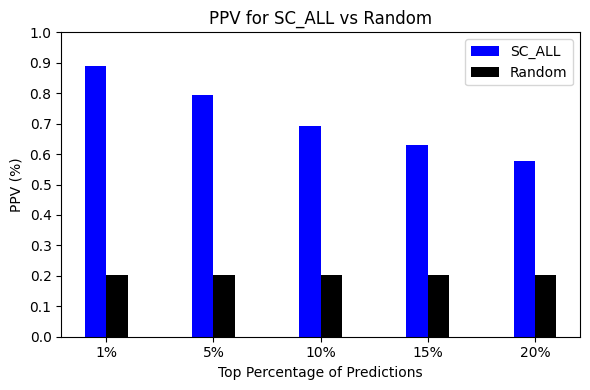

Running classifier SC_GENPROT
--------------------------------------------------
upstream_size                     3
downstream_size                   2
paralagous_count                  3
phyletic_retention                6
promoter_count(Harbison_et_al)    2
dtype: int64
Data loaded successfully, shape: (4728, 42) (4728,)
Starting to find optimal number of features...
Features: 16, PPV (1%): 0.812173913043478, PPV (5%): 0.6587288135593221
Features: 15, PPV (1%): 0.8199999999999998, PPV (5%): 0.671101694915254
Features: 14, PPV (1%): 0.8247826086956515, PPV (5%): 0.6591525423728812
Features: 13, PPV (1%): 0.8186956521739127, PPV (5%): 0.6779661016949151
Features: 12, PPV (1%): 0.8299999999999996, PPV (5%): 0.6932203389830507
Features: 11, PPV (1%): 0.8360869565217385, PPV (5%): 0.7190677966101695
Features: 10, PPV (1%): 0.8347826086956514, PPV (5%): 0.7151694915254244
Features: 9, PPV (1%): 0.8630434782608688, PPV (5%): 0.7004237288135597
Features: 8, PPV (1%): 0.8360869565217389, PPV

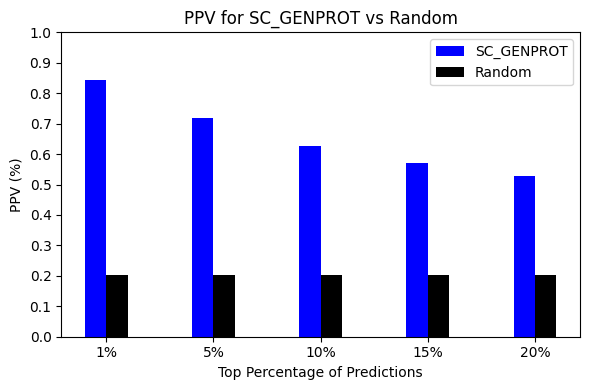

Running classifier SC_NO_GENPROT
--------------------------------------------------
upstream_size                     3
downstream_size                   2
paralagous_count                  3
phyletic_retention                6
promoter_count(Harbison_et_al)    2
dtype: int64
Data loaded successfully, shape: (4728, 42) (4728,)
Starting to find optimal number of features...
Features: 15, PPV (1%): 0.651739130434783, PPV (5%): 0.5166949152542373
Features: 14, PPV (1%): 0.6113043478260871, PPV (5%): 0.5238135593220339
Features: 13, PPV (1%): 0.61304347826087, PPV (5%): 0.530593220338983
Features: 12, PPV (1%): 0.5595652173913046, PPV (5%): 0.447457627118644
Features: 11, PPV (1%): 0.5543478260869571, PPV (5%): 0.45211864406779645
Features: 10, PPV (1%): 0.535217391304348, PPV (5%): 0.46262711864406747
Features: 9, PPV (1%): 0.4669565217391303, PPV (5%): 0.5039830508474578
Features: 8, PPV (1%): 0.4852173913043478, PPV (5%): 0.5148305084745761
Features: 7, PPV (1%): 0.5378260869565219, PPV

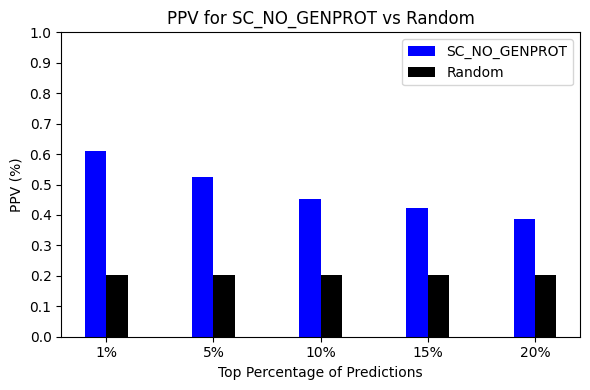

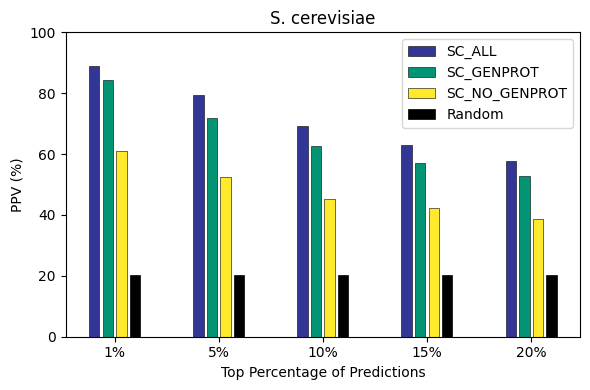

,1%,5%,10%,15%,20%,Number of Features
Classifier,,,,,,
SC_ALL,0.89,0.79,0.69,0.63,0.58,21
SC_GENPROT,0.84,0.72,0.63,0.57,0.53,11
SC_NO_GENPROT,0.61,0.53,0.45,0.42,0.39,13


In [373]:


classifier_no_genprot = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_NO_GENPROT, PERCENTILES, name='SC_NO_GENPROT')
classifier_genprot = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_GENPROT, PERCENTILES, name='SC_GENPROT')
classifier_all = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, name='SC_ALL')

experiment = EssentialityExperiment("S. cerevisiae", [classifier_all, classifier_genprot, classifier_no_genprot])
experiment.run_experiment()
experiment.plot_and_save_comparative_results(PERCENTILES, colors=COLORS)
experiment.plot_and_save_comparative_table()



In [374]:


classifier_no_genprot = EssentialityRandomForestClassifier('cerevisiae_data.xls', CMIM_SC_NO_GENPROT, PERCENTILES, ITERATIONS, name='SC_NO_GENPROT')
classifier_genprot = EssentialityRandomForestClassifier('cerevisiae_data.xls', CMIM_SC_GENPROT, PERCENTILES, ITERATIONS, name='SC_GENPROT')
classifier_all = EssentialityRandomForestClassifier('cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, ITERATIONS, name='SC_ALL')

experiment = EssentialityExperiment("S. cerevisiae Random Forest", [classifier_all,classifier_genprot, classifier_no_genprot])
experiment.run_experiment()
experiment.plot_and_save_comparative_results(PERCENTILES, colors=['#323694', '#039573', '#feea2a'])



TypeError: EssentialityRandomForestClassifier.__init__() got multiple values for argument 'name'